In [75]:
import os
import zipfile
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from skimage import io
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from sklearn.model_selection import train_test_split
from google_drive_downloader import GoogleDriveDownloader as gdd

In [76]:
gdd.download_file_from_google_drive(file_id="1MVOOPBvdjc05Muv9AkgujwOvV1PlOi8-",
                                    dest_path="./train.zip",
                                    unzip=False)
gdd.download_file_from_google_drive(file_id="1SJ9lZgcnc6KnVgOrpbPnLveTXtsWd6Ms",
                                    dest_path="./test.zip",
                                    unzip=False)

In [77]:
def download_data(path):
  data = []
  for path_image in sorted(os.listdir(path=path)):
    image = Image.open(path + path_image) #Открываем изображение.
    image = tf.image.resize(image, (128, 128), method="nearest")
    data.append(np.array(image)) #Загружаем пиксели.
  return data

In [78]:
data_r = zipfile.ZipFile('train.zip', 'r')
data_r.extractall()

data_r = zipfile.ZipFile('test.zip', 'r')
data_r.extractall()

In [79]:
X_train = download_data(r"train/images/")
Y_train = download_data(r"train/masks/")
X_test = download_data(r"test/images/")
Y_test = download_data(r"test/masks/")

array([[[238, 241, 246],
        [185, 190, 196],
        [249, 255, 255],
        ...,
        [178, 177, 185],
        [220, 219, 225],
        [235, 237, 250]],

       [[254, 255, 255],
        [252, 255, 255],
        [250, 251, 253],
        ...,
        [213, 209, 223],
        [199, 192, 199],
        [152, 145, 152]],

       [[194, 194, 196],
        [239, 238, 243],
        [253, 254, 255],
        ...,
        [ 96,  88, 101],
        [157, 142, 149],
        [148, 132, 133]],

       ...,

       [[213, 207, 217],
        [238, 233, 239],
        [211, 208, 219],
        ...,
        [247, 240, 234],
        [218, 211, 203],
        [241, 234, 224]],

       [[231, 225, 235],
        [166, 161, 167],
        [211, 208, 219],
        ...,
        [255, 253, 250],
        [237, 230, 222],
        [223, 216, 208]],

       [[246, 240, 250],
        [198, 191, 198],
        [199, 197, 208],
        ...,
        [240, 237, 230],
        [249, 238, 232],
        [255, 253, 243]]], dtype=uint8)
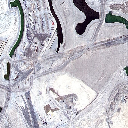

In [80]:
X_train[0]

In [81]:
palette = {0 : (60, 16, 152), # Building
           1 : (132, 41, 246), # Land
           2 : (110, 193, 228), # Road
           3 : (254, 221, 58), # Vegetation
           4 : (226, 169, 41), # Water
           5 : (155, 155, 155)} # Unlabeled
Y_train[0][0][0] #Land

array([132,  41, 246, 255], dtype=uint8)

In [82]:
invert_palette = {v: k for k, v in palette.items()}

In [83]:
def convert_from_color(arr_3d, palette=invert_palette):
    """ RGB-color encoding to grayscale labels """
    arr_2d = np.zeros((arr_3d.shape[0], arr_3d.shape[1]), dtype=np.uint8)

    arr_2d = np.zeros((arr_3d.shape[0], arr_3d.shape[1]), dtype=np.int8) # принадлежность каждого пикселя классу
    min_distance = np.zeros((arr_3d.shape[0], arr_3d.shape[1]), dtype=np.float32)+1000 # расстояние до ближайшего класса для пикселей
    for c, i in palette.items():
      distance = np.sum((arr_3d - np.array(c).reshape(1, 1, 3))**2, axis=-1)**(1/2) # ищем расстояние для каждого пикселя до проверяемого класса по евклиду рас-ие
      condition = min_distance > distance # поиск элементов меньше min_distance
      min_distance[condition] = distance[condition] # замена дистанции найденных элементов
      arr_2d[condition] = i # замена класса найденных элементов

    for c, i in palette.items():
      m = np.all(arr_3d == np.array(c).reshape(1, 1, 3), axis=2)
      arr_2d[m] = i

    arr_2d = arr_2d.tolist()
    for i in range(len(arr_2d)):
      for j in range(len(arr_2d[0])):
        label = [0, 0, 0, 0, 0, 0]
        label[arr_2d[i][j]] = 1
        arr_2d[i][j] = label
    arr_2d = np.array(arr_2d)

    return arr_2d

In [84]:
# сегментация нейронной сети в RGB изображение
def convert_to_color(arr_2d, palette=palette):
    """ Numeric labels to RGB-color encoding """
    arr_3d = np.zeros((arr_2d.shape[0], arr_2d.shape[1], 3), dtype=np.uint8)

    for c, i in palette.items():
        m = arr_2d == c
        arr_3d[m] = i

    return arr_3d

In [85]:
# Binary crossentropy + 0.25 * DICE
def dice_bce_loss(y_pred, y_true):
    total_loss = 0.25 * dice_loss(y_pred, y_true) + tf.keras.losses.binary_crossentropy(y_pred, y_true)
    return total_loss

In [86]:
def unet_model(image_size, output_classes):

    #Входной слой
    input_layer = Input(shape=image_size + (3,))
    conv_1 = Conv2D(64, 4,
                                    activation=LeakyReLU(),
                                    strides=2, padding='same',
                                    kernel_initializer='glorot_normal',
                                    use_bias=False)(input_layer)
    #Сворачиваем
    #1
    conv_1_1 = Conv2D(128, 4,
                                      activation=LeakyReLU(),
                                      strides=2,
                                      padding='same',
                                      kernel_initializer='glorot_normal',
                                      use_bias=False)(conv_1)
    batch_norm_1 = BatchNormalization()(conv_1_1)

    #2
    conv_2 = Conv2D(256, 4,
                                    activation=LeakyReLU(),
                                    strides=2,
                                    padding='same',
                                    kernel_initializer='glorot_normal',
                                    use_bias=False)(batch_norm_1)
    batch_norm_2 = BatchNormalization()(conv_2)

    #3
    conv_3 = Conv2D(512, 4,
                                    activation=LeakyReLU(),
                                    strides=2,
                                    padding='same',
                                    kernel_initializer='glorot_normal',
                                    use_bias=False)(batch_norm_2)
    batch_norm_3 = BatchNormalization()(conv_3)

    #4
    conv_4 = Conv2D(512, 4,
                                    activation=LeakyReLU(),
                                    strides=2,
                                    padding='same',
                                    kernel_initializer='glorot_normal',
                                    use_bias=False)(batch_norm_3)
    batch_norm_4 = BatchNormalization()(conv_4)

    #5
    conv_5 = Conv2D(512, 4,
                                    activation=LeakyReLU(),
                                    strides=2,
                                    padding='same',
                                    kernel_initializer='glorot_normal',
                                    use_bias=False)(batch_norm_4)
    batch_norm_5 = BatchNormalization()(conv_5)

    #6
    conv_6 = Conv2D(512, 4,
                                    activation=LeakyReLU(),
                                    strides=2,
                                    padding='same',
                                    kernel_initializer='glorot_normal',
                                    use_bias=False)(batch_norm_5)
    #Разворачиваем
    #1
    up_1 = Concatenate()([Conv2DTranspose(512, 4, activation='relu', strides=2,
                                                                          padding='same',
                                                                          kernel_initializer='glorot_normal',
                                                                          use_bias=False)(conv_6), conv_5])
    batch_up_1 = BatchNormalization()(up_1)

    #Добавим Dropout от переобучения
    batch_up_1 = Dropout(0.25)(batch_up_1)

    #2
    up_2 = Concatenate()([Conv2DTranspose(512, 4, activation='relu', strides=2,
                                                                          padding='same',
                                                                          kernel_initializer='glorot_normal',
                                                                          use_bias=False)(batch_up_1), conv_4])
    batch_up_2 = BatchNormalization()(up_2)
    batch_up_2 = Dropout(0.25)(batch_up_2)




    #3
    up_3 = Concatenate()([Conv2DTranspose(512, 4, activation='relu', strides=2,
                                                                          padding='same',
                                                                          kernel_initializer='glorot_normal',
                                                                          use_bias=False)(batch_up_2), conv_3])
    batch_up_3 = BatchNormalization()(up_3)
    batch_up_3 = Dropout(0.25)(batch_up_3)




    #4
    up_4 = Concatenate()([Conv2DTranspose(256, 4, activation='relu', strides=2,
                                                                          padding='same',
                                                                          kernel_initializer='glorot_normal',
                                                                          use_bias=False)(batch_up_3), conv_2])
    batch_up_4 = BatchNormalization()(up_4)


    #5
    up_5 = Concatenate()([Conv2DTranspose(128, 4, activation='relu', strides=2,
                                                                          padding='same',
                                                                          kernel_initializer='glorot_normal',
                                                                          use_bias=False)(batch_up_4), conv_1_1])
    batch_up_5 = BatchNormalization()(up_5)


    #6
    up_6 = Concatenate()([Conv2DTranspose(64, 4, activation='relu', strides=2,
                                                                          padding='same',
                                                                          kernel_initializer='glorot_normal',
                                                                          use_bias=False)(batch_up_5), conv_1])
    batch_up_6 = BatchNormalization()(up_6)


    #Выходной слой
    output_layer = Conv2DTranspose(output_classes, 4, activation='sigmoid', strides=2,
                                                   padding='same',
                                                   kernel_initializer='glorot_normal')(batch_up_6)

    model = Model(inputs=input_layer, outputs=output_layer)

    return model

In [87]:
X_train_fit, X_test_fit, Y_train_fit, Y_test_fit = train_test_split(X_train, Y_train, test_size=0.2)

X_train_pred = np.array(X_train_fit).reshape([5, 128, 128, 3]) / 255
X_valid_pred = np.array(X_test_fit).reshape([2, 128, 128, 3]) / 255
X_test_pred = np.array(X_test).reshape([2, 128, 128, 3]) / 255

Y_train_pred = []
for i in range(len(Y_train_fit)):
  Y_train_pred.append(convert_from_color(Y_train_fit[i][:, :, :3]))
Y_train_pred = np.array(Y_train_pred)

Y_valid_pred = []
for i in range(len(Y_test_fit)):
  Y_valid_pred.append(convert_from_color(Y_test_fit[i][:, :, :3]))
Y_valid_pred = np.array(Y_valid_pred)

Y_test_pred = []
for i in range(len(Y_test)):
  Y_test_pred.append(convert_from_color(Y_test[i][:, :, :3]))
Y_test_pred = np.array(Y_test_pred)

In [88]:
%%time
model = unet_model((128, 128), 6)
model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss="categorical_crossentropy",
                  metrics="accuracy")
history = model.fit(X_train_pred, Y_train_pred,  epochs=10, validation_data = (X_valid_pred, Y_valid_pred))

Epoch 1/10
1/1 [==============================] - 7s 7s/step - loss: 1.9540 - accuracy: 0.1538 - val_loss: 1.7384 - val_accuracy: 0.3304
Epoch 2/10
1/1 [==============================] - 4s 4s/step - loss: 1.6175 - accuracy: 0.4295 - val_loss: 1.6821 - val_accuracy: 0.5624
Epoch 3/10
1/1 [==============================] - 3s 3s/step - loss: 1.4390 - accuracy: 0.5655 - val_loss: 1.6350 - val_accuracy: 0.5692
Epoch 4/10
1/1 [==============================] - 3s 3s/step - loss: 1.3186 - accuracy: 0.6177 - val_loss: 1.6021 - val_accuracy: 0.5824
Epoch 5/10
1/1 [==============================] - 3s 3s/step - loss: 1.2423 - accuracy: 0.6630 - val_loss: 1.5920 - val_accuracy: 0.6047
Epoch 6/10
1/1 [==============================] - 4s 4s/step - loss: 1.1495 - accuracy: 0.7079 - val_loss: 1.5598 - val_accuracy: 0.5753
Epoch 7/10
1/1 [==============================] - 3s 3s/step - loss: 1.0846 - accuracy: 0.7164 - val_loss: 1.5309 - val_accuracy: 0.6090
Epoch 8/10
1/1 [=========================

In [89]:
predict = model.predict(X_test_pred)

predict = tf.argmax(predict, axis=-1)

1/1 [==============================] - 1s 1s/step


array([[[251, 242, 235],
        [230, 221, 222],
        [207, 198, 203],
        ...,
        [206, 205, 211],
        [235, 239, 242],
        [ 67,  67,  79]],

       [[220, 212, 210],
        [216, 213, 220],
        [209, 207, 218],
        ...,
        [219, 222, 227],
        [254, 255, 255],
        [105,  93, 103]],

       [[244, 239, 243],
        [178, 173, 177],
        [196, 191, 195],
        ...,
        [217, 224, 230],
        [215, 219, 228],
        [197, 181, 192]],

       ...,

       [[221, 220, 226],
        [211, 210, 218],
        [203, 200, 219],
        ...,
        [ 16,  25,  20],
        [ 11,  17,  15],
        [ 23,  29,  27]],

       [[195, 196, 200],
        [209, 209, 219],
        [188, 186, 208],
        ...,
        [ 22,  31,  26],
        [  0,   4,   2],
        [  8,  14,  12]],

       [[197, 200, 207],
        [232, 235, 250],
        [188, 194, 216],
        ...,
        [ 28,  37,  32],
        [  3,  12,   9],
        [ 11,  17,  15]]], dtype=uint8)
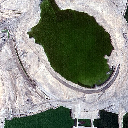

array([[[132,  41, 246],
        [132,  41, 246],
        [132,  41, 246],
        ...,
        [132,  41, 246],
        [132,  41, 246],
        [132,  41, 246]],

       [[132,  41, 246],
        [132,  41, 246],
        [132,  41, 246],
        ...,
        [132,  41, 246],
        [132,  41, 246],
        [132,  41, 246]],

       [[132,  41, 246],
        [132,  41, 246],
        [132,  41, 246],
        ...,
        [132,  41, 246],
        [132,  41, 246],
        [132,  41, 246]],

       ...,

       [[132,  41, 246],
        [132,  41, 246],
        [132,  41, 246],
        ...,
        [132,  41, 246],
        [132,  41, 246],
        [132,  41, 246]],

       [[132,  41, 246],
        [132,  41, 246],
        [132,  41, 246],
        ...,
        [132,  41, 246],
        [132,  41, 246],
        [132,  41, 246]],

       [[132,  41, 246],
        [132,  41, 246],
        [132,  41, 246],
        ...,
        [132,  41, 246],
        [132,  41, 246],
        [132,  41, 246]]], dtype=uint8)
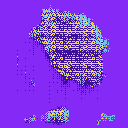

(None, None)

In [90]:
display(X_test[0]), display(convert_to_color(predict[0]))